# Fraud Analytics Case Study 

1- Exploratory Data Analysis
* Undertanding Target Varible
* Bivariate Relationships: 
    * Time Variables
    * Numerical Variables
    * Categorical Varibles
* Multivariate Relationships

2- Segments & Metrics 

3- Metric Calculations by Segments


In [1]:
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import datetime

# calling functions from the util.py file
from util import (
    countplot_viz,
    distplot_viz,
    countplot_pointplot_viz,
    countplot_pointplot_viz_top15,
    df_descriptive_statistics,
    fraud_ratio_calculator_for_two_categoric_variables,
    fraud_ratio_calculator_for_numeric_categoric_variables,
)

from datetime import datetime
from datetime import timedelta


# ignoring warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = None

# adding useful magic functions
%load_ext lab_black
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
# Uploading data set
df_data = pd.read_csv("mondu_fraud_case_study.csv")

In [3]:
df_data.head()

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,ip_address,user_agent,email_domain,phone_number,billing_city,billing_postal,billing_state,card_bin,currency,cvv,signature_image,transaction_type,transaction_env,EVENT_TIMESTAMP,applicant_name,billing_address,merchant_id,locale,tranaction_initiate,days_since_last_logon,inital_amount,EVENT_LABEL
0,3371.0,2167.0,56.0,2572.0,154.68.49.124,Opera/9.81.(Windows NT 10.0; ht-HT) Presto/2.9...,perez-garza.com,878-111-5140,Woodsburgh,96336.0,California,40771.0,cad,D,F,U,X,29.12.20 09:05,Linda Wright,4684 Sharon Ranch,066-82-8795,niu_NZ,O,59.0,13646.0,legit
1,2714.0,2045.0,48.0,4517.0,39.131.125.85,Opera/9.76.(X11; Linux i686; mi-NZ) Presto/2.9...,mcneil-ortega.com,(002)736-0139,West Kevin,78083.0,Florida,24480.0,cad,X,X,H,W,22.06.21 18:05,Terri Rivera,7642 Allison Ramp,669-99-9459,apn_IN,J,0.0,11930.0,legit
2,6987.0,2892.0,61.0,5007.0,166.245.194.83,Mozilla/5.0 (X11; Linux x86_64; rv:1.9.6.20) G...,davis-calderon.com,(983)585-2863x652,Lorichester,83236.0,Utah,37778.0,cad,X,Q,X,X,10.05.21 13:48,Sarah Gray,4948 Lisa Passage,086-41-1624,dv_MV,T,83.0,7412.0,legit
3,2712.0,3040.0,28.0,6022.0,100.1.217.216,Mozilla/5.0 (Macintosh; Intel Mac OS X 10 9_3 ...,rose-lee.org,+1-678-897-3420x60738,Stephenmouth,78364.0,Virginia,55790.0,usd,G,G,C,N,11.03.21 07:36,Valerie Jenkins,1616 Little Camp,669-97-4021,byn_ER,M,24.0,4623.0,legit
4,3598.0,2976.0,66.0,2600.0,113.156.65.245,Mozilla/5.0 (X11; Linux x86_64; rv:1.9.5.20) G...,nash.net,(013)204-1766x92641,New Brianmouth,77499.0,South Carolina,37370.0,cad,X,F,F,G,27.03.21 06:13,Amy Coleman,149 Harris Rapid,088-21-6329,the_NP,K,21.0,1905.0,legit


# 1.-Exploratory Data Analysis: 

In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   account_age_days       149892 non-null  float64
 1   transaction_amt        149870 non-null  float64
 2   transaction_adj_amt    149886 non-null  float64
 3   historic_velocity      149885 non-null  float64
 4   ip_address             149873 non-null  object 
 5   user_agent             149887 non-null  object 
 6   email_domain           149910 non-null  object 
 7   phone_number           149873 non-null  object 
 8   billing_city           149884 non-null  object 
 9   billing_postal         149876 non-null  float64
 10  billing_state          149887 non-null  object 
 11  card_bin               149872 non-null  float64
 12  currency               149892 non-null  object 
 13  cvv                    149877 non-null  object 
 14  signature_image        149895 non-nu

In [5]:
# Adding new column for using in the raio calculations:

df_data["EVENT_LABEL_"] = np.where(df_data["EVENT_LABEL"] == "fraud", 1, 0)

## Understanding  Target Varible: Event Label

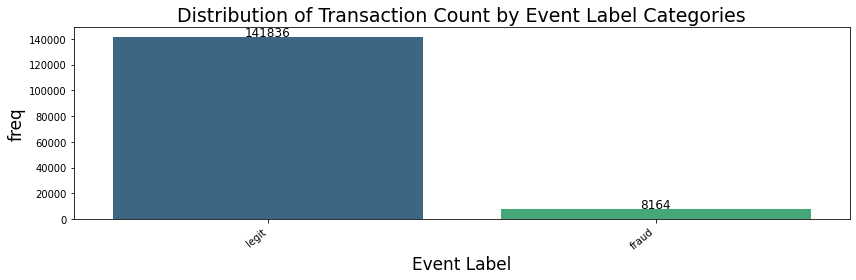

In [6]:
# Distribution of transaction counts by whether fraud or not:

countplot_viz(
    df_data,
    "EVENT_LABEL",
    "Event Label",
    "freq",
    "Distribution of Transaction Count by Event Label Categories",
    figsize_x=12,
    figsize_y=4,
    palette="viridis",
)

In [7]:
# EVENT_LABEL column ratio:

df_data.groupby(by=["EVENT_LABEL"])["transaction_amt"].count() / df_data[
    "transaction_amt"
].count()

EVENT_LABEL
fraud    0.05442
legit    0.94558
Name: transaction_amt, dtype: float64

* There are 2 different categories as the event labels: Fraud and Legit.
* Rate of the fraudelent activities in total activities is 0.0544.

## Bivariate Relationships: Time Variables

### Event Timestamp & Event Label:

In [8]:
# Changing type of EVENT_TIMESTAMP column from object to datetime:

df_data["EVENT_TIMESTAMP"] = pd.to_datetime(df_data["EVENT_TIMESTAMP"])

In [9]:
# Adding new columns to detaily time analysis as year, month, weekday, hour and day:

df_data["Weekday"] = df_data[
    "EVENT_TIMESTAMP"
].dt.dayofweek  # To see Weekdays of the week
df_data["Hour"] = df_data["EVENT_TIMESTAMP"].dt.hour  # To see hours of the day
df_data["Day"] = df_data["EVENT_TIMESTAMP"].dt.day  # To see days of the month
df_data["Year"] = df_data["EVENT_TIMESTAMP"].dt.year  # To see years of the column
df_data["Month"] = df_data["EVENT_TIMESTAMP"].dt.month  # To see months of the column

#### Yearly check:

In [10]:
# To see which years we have in the dataset:

df_data["Year"].unique()

array([2020., 2021.,   nan])

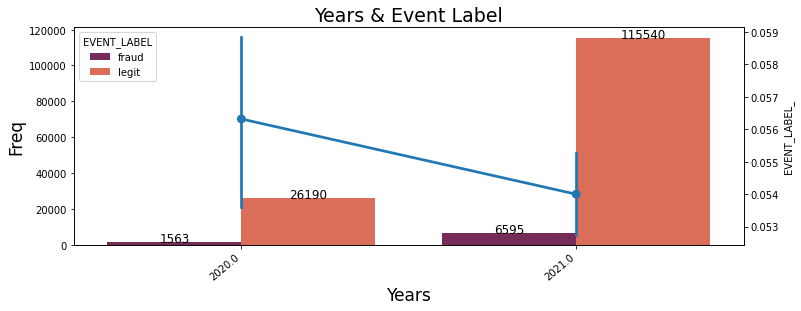

In [11]:
# To see count of fraud and legit transaction for each value in Year column:

filter_list = ["fraud", "legit"]
countplot_pointplot_viz(
    df_data,
    filter_list,
    "Year",
    "EVENT_LABEL",
    "EVENT_LABEL_",
    "Years",
    "Freq",
    "Years & Event Label",
    palette="rocket",
    figsize_x=12,
    figsize_y=4,
)

__Findings__: 
* 2021 is the highest fraudelent activity year 
* 2020 is the highest fraudelent activity ratio year 

#### Monthly check:

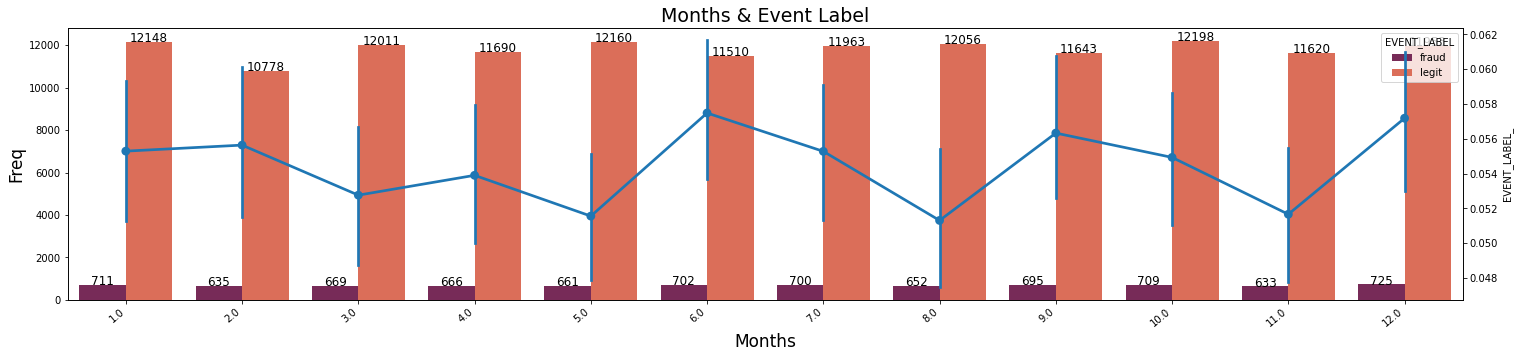

In [12]:
# To see count of fraud and legit transaction for each value in Month column:

filter_list = ["fraud", "legit"]
countplot_pointplot_viz(
    df_data,
    filter_list,
    "Month",
    "EVENT_LABEL",
    "EVENT_LABEL_",
    "Months",
    "Freq",
    "Months & Event Label",
    palette="rocket",
    figsize_x=25,
    figsize_y=5,
)

__Findings__:
 * Highest fraudelent activities are in December, June and September

#### Day of the Week Check:

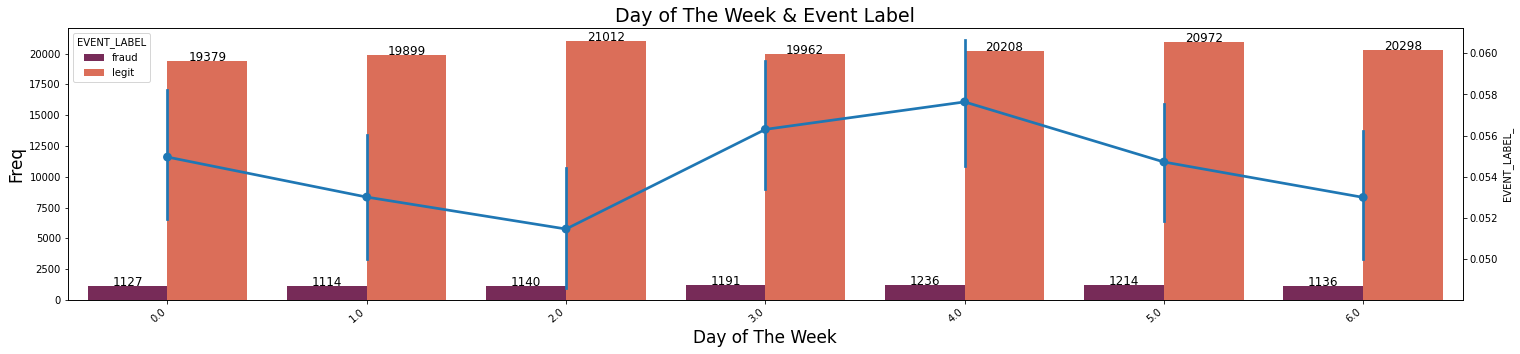

In [13]:
# The day of the week starts with Monday=0 and ends with Sunday=6. To see count of fraud and legit transaction for each value in Day of Week column:

filter_list = ["fraud", "legit"]
countplot_pointplot_viz(
    df_data,
    filter_list,
    "Weekday",
    "EVENT_LABEL",
    "EVENT_LABEL_",
    "Day of The Week",
    "Freq",
    "Day of The Week & Event Label",
    palette="rocket",
    figsize_x=25,
    figsize_y=5,
)

__Findings__:
* Friday has the highest fraudelent activitie count and ratio. 

#### Day of Month Check: 

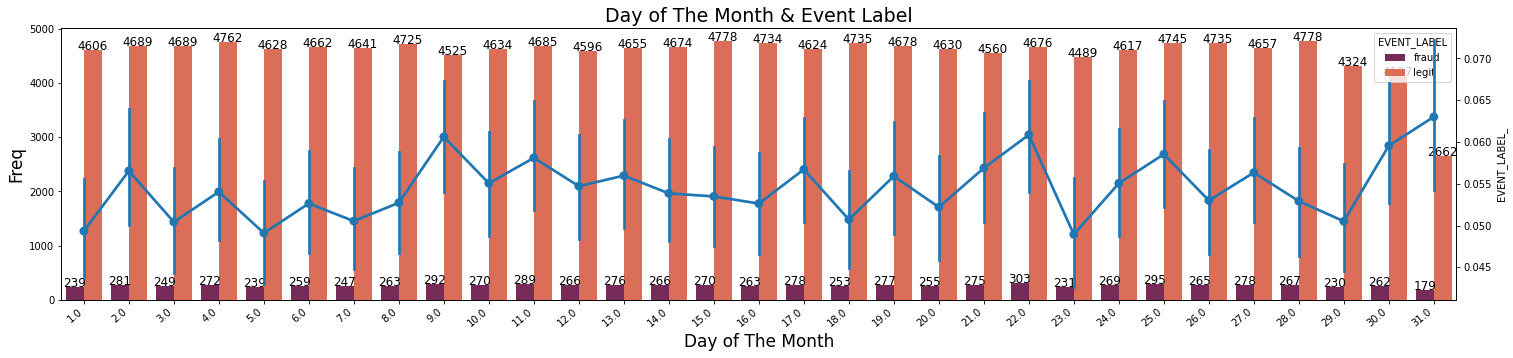

In [14]:
# The day of the months starts with 1 and ends with 31. To see count of fraud and legit transaction for each value in Day of Month column:

filter_list = ["fraud", "legit"]
countplot_pointplot_viz(
    df_data,
    filter_list,
    "Day",
    "EVENT_LABEL",
    "EVENT_LABEL_",
    "Day of The Month",
    "Freq",
    "Day of The Month & Event Label",
    palette="rocket",
    figsize_x=25,
    figsize_y=5,
)

__Findings__: 
* On 31th, 22th and 9th we observe the higestes fraudelent activity ratio.  

#### Hour of Day Check: 

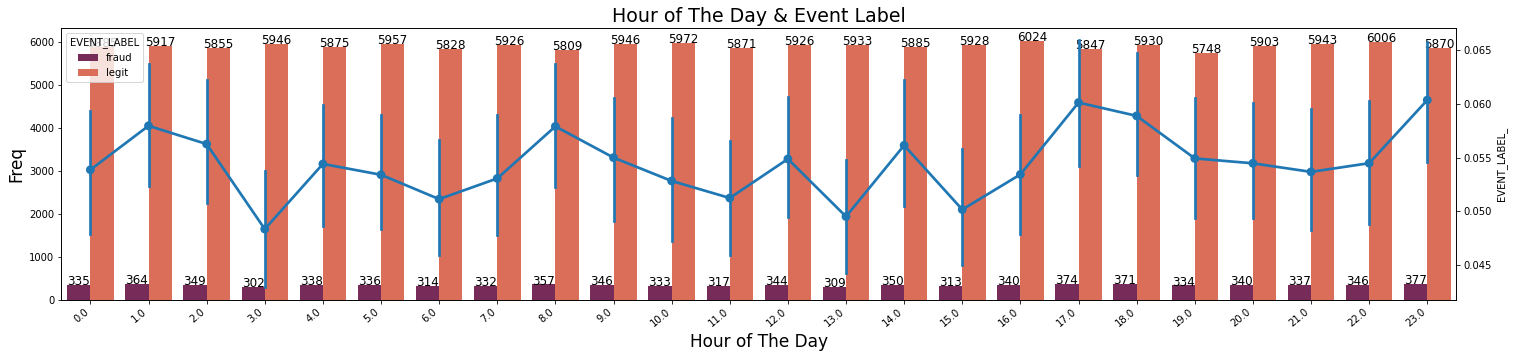

In [15]:
# The hours of day with 24=0.0, 1=1.0, etc. To see count of fraud and legit transaction for each value in Hour of the Day column:

filter_list = ["fraud", "legit"]
countplot_pointplot_viz(
    df_data,
    filter_list,
    "Hour",
    "EVENT_LABEL",
    "EVENT_LABEL_",
    "Hour of The Day",
    "Freq",
    "Hour of The Day & Event Label",
    palette="rocket",
    figsize_x=25,
    figsize_y=5,
)

__Findings__: 
* At 23, 17 and 18 we observe the highest fraudelent activity ratio. 
    * It shows that at late and after work hours fraudelent activities occur more. 

## Bivariate Relationships: Numerics Variables

### Transaction Amount & Event Label:

__Assumption__: 

Transactions are happening in different currencies. When I compare Euro to Canada and America Dollars, I see that maximum ratio is 1.8 in the last 2 years. Which means I will not apply a currency scaling in here. But in a real project we need to convert them to the same scale for appropriate comparison.

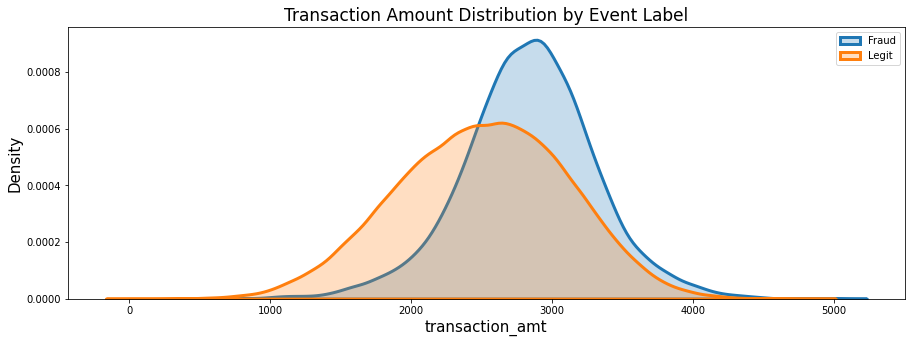

In [16]:
# To see transaction amount distribution for EVENT_LABEL column:
distplot_viz(
    data=df_data,
    column="transaction_amt",
    separate_column="EVENT_LABEL",
    condition_1="fraud",
    condition_2="legit",
    label1="Fraud",
    label2="Legit",
    title="Transaction Amount Distribution by Event Label",
    color1="blue",
    color2="red",
)

In [17]:
list_of_column_descriptive = ["transaction_amt"]
print("Fraud transactions; \n")
df_descriptive_statistics(
    df_data[df_data["EVENT_LABEL"] == "fraud"], list_of_column_descriptive
)
print("Legit transactions; \n")
df_descriptive_statistics(
    df_data[df_data["EVENT_LABEL"] == "legit"], list_of_column_descriptive
)

Fraud transactions; 

       transaction_amt
count      8156.000000
mean       2833.471187
std         474.385893
min         814.000000
25%        2545.000000
50%        2841.000000
75%        3130.000000
max        4999.000000

Mode: 
    transaction_amt
0           2836.0

Legit transactions; 

       transaction_amt
count    141714.000000
mean       2503.501849
std         606.305683
min           5.000000
25%        2081.000000
50%        2519.000000
75%        2935.000000
max        4844.000000

Mode: 
    transaction_amt
0           2275.0



__Findings__: 
* Fraudelent transactions have smaller variance compared to legit transactions.  
* Fraudelent transaction's minimum value is 175 times bigger than legit transactions.
* These information shows that fraudelent people only focuses on certain amount of transactions. Small numbers are not important for them.

### Account Age & Event Label:

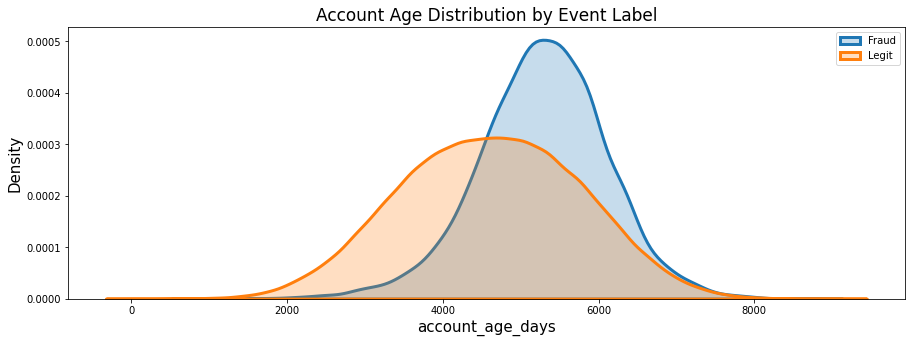

In [18]:
# To see transaction amount distribution for Account Age column:

distplot_viz(
    data=df_data,
    column="account_age_days",
    separate_column="EVENT_LABEL",
    condition_1="fraud",
    condition_2="legit",
    label1="Fraud",
    label2="Legit",
    title="Account Age Distribution by Event Label",
    color1="blue",
    color2="red",
)

In [19]:
list_of_column_descriptive = ["account_age_days"]
print("Fraud transactions; \n")
df_descriptive_statistics(
    df_data[df_data["EVENT_LABEL"] == "fraud"], list_of_column_descriptive
)
print("Legit transactions; \n")
df_descriptive_statistics(
    df_data[df_data["EVENT_LABEL"] == "legit"], list_of_column_descriptive
)

Fraud transactions; 

       account_age_days
count       8158.000000
mean        5275.526354
std          831.440621
min          931.000000
25%         4762.250000
50%         5298.000000
75%         5819.000000
max         8722.000000

Mode: 
    account_age_days
0            5105.0
1            5168.0

Legit transactions; 

       account_age_days
count     141734.000000
mean        4609.503111
std         1159.306448
min            1.000000
25%         3780.000000
50%         4615.000000
75%         5439.750000
max         9119.000000

Mode: 
    account_age_days
0            4616.0



__Findings__:
* Fraudelent transactions have smaller variance compared to legit transactions.  
* Fraudelent transaction's minimum value is 931 times bigger than legit transactions.
* These information shows that fraudelent people only focuses on accounts are older than 3.5 years. Newly created accounts are not in their target group.

### Days Since Last Logon & Event Label:

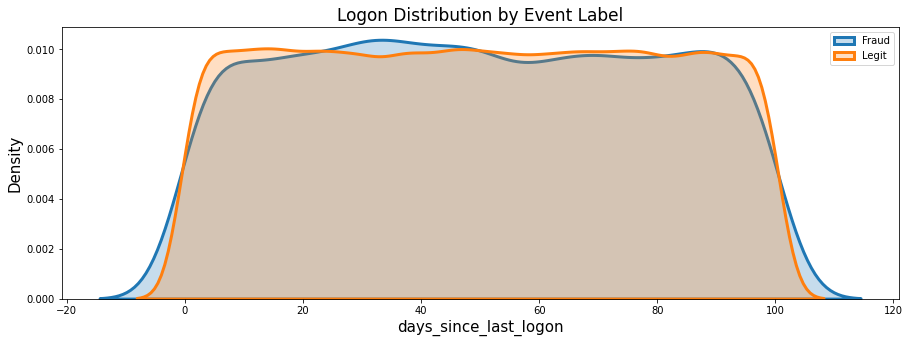

In [20]:
# To see transaction amount distribution for Account Days Since Last Logon column:

distplot_viz(
    data=df_data,
    column="days_since_last_logon",
    separate_column="EVENT_LABEL",
    condition_1="fraud",
    condition_2="legit",
    label1="Fraud",
    label2="Legit",
    title="Logon Distribution by Event Label",
    color1="blue",
    color2="red",
)

In [21]:
list_of_column_descriptive = ["days_since_last_logon"]
print("Fraud transactions; \n")
df_descriptive_statistics(
    df_data[df_data["EVENT_LABEL"] == "fraud"], list_of_column_descriptive
)
print("Legit transactions; \n")
df_descriptive_statistics(
    df_data[df_data["EVENT_LABEL"] == "legit"], list_of_column_descriptive
)

Fraud transactions; 

       days_since_last_logon
count            8155.000000
mean               49.808584
std                29.181661
min                 0.000000
25%                25.000000
50%                49.000000
75%                75.000000
max               100.000000

Mode: 
    days_since_last_logon
0                   51.0

Legit transactions; 

       days_since_last_logon
count          141709.000000
mean               49.869719
std                29.206195
min                 0.000000
25%                24.000000
50%                50.000000
75%                75.000000
max               100.000000

Mode: 
    days_since_last_logon
0                   36.0



__Findings__:
* Fraudelent and legit distributions are approximately similar.  

### Inital Amount & Event Label:  

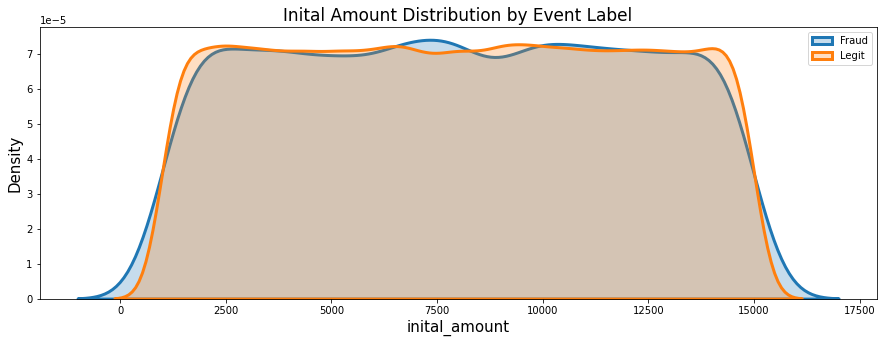

In [22]:
# To see transaction amount distribution for Initial Amount column:

distplot_viz(
    data=df_data,
    column="inital_amount",
    separate_column="EVENT_LABEL",
    condition_1="fraud",
    condition_2="legit",
    label1="Fraud",
    label2="Legit",
    title="Inital Amount Distribution by Event Label",
    color1="blue",
    color2="red",
)

In [23]:
list_of_column_descriptive = ["inital_amount"]
print("Fraud transactions; \n")
df_descriptive_statistics(
    df_data[df_data["EVENT_LABEL"] == "fraud"], list_of_column_descriptive
)
print("Legit transactions; \n")
df_descriptive_statistics(
    df_data[df_data["EVENT_LABEL"] == "legit"], list_of_column_descriptive
)

Fraud transactions; 

       inital_amount
count    8154.000000
mean     7990.473019
std      4046.830103
min      1001.000000
25%      4464.750000
50%      7941.500000
75%     11471.750000
max     14999.000000

Mode: 
    inital_amount
0         5239.0

Legit transactions; 

       inital_amount
count  141718.000000
mean     7998.459808
std      4047.099300
min      1000.000000
25%      4488.000000
50%      8006.000000
75%     11495.750000
max     15000.000000

Mode: 
    inital_amount
0         7249.0



__Findings__: 
* Fraudelent and legit distributions are approximately similar. 

### Adjusted Transaction Amount & Event Label:  

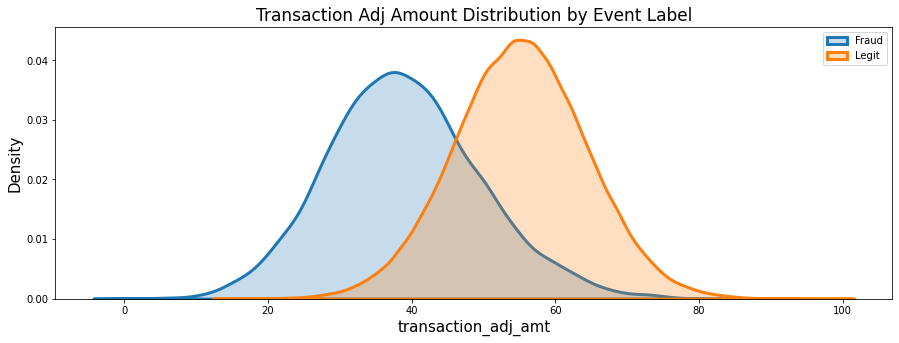

In [24]:
# To see transaction amount distribution for Adjusted Transaction Amount column:

distplot_viz(
    data=df_data,
    column="transaction_adj_amt",
    separate_column="EVENT_LABEL",
    condition_1="fraud",
    condition_2="legit",
    label1="Fraud",
    label2="Legit",
    title="Transaction Adj Amount Distribution by Event Label",
    color1="blue",
    color2="red",
)

In [25]:
list_of_column_descriptive = ["transaction_adj_amt"]
print("Fraud transactions; \n")
df_descriptive_statistics(
    df_data[df_data["EVENT_LABEL"] == "fraud"], list_of_column_descriptive
)
print("Legit transactions; \n")
df_descriptive_statistics(
    df_data[df_data["EVENT_LABEL"] == "legit"], list_of_column_descriptive
)

Fraud transactions; 

       transaction_adj_amt
count          8154.000000
mean             38.921511
std              10.656034
min               1.000000
25%              32.000000
50%              38.000000
75%              46.000000
max              78.000000

Mode: 
    transaction_adj_amt
0                 38.0

Legit transactions; 

       transaction_adj_amt
count        141732.000000
mean             55.081562
std               9.300999
min              15.000000
25%              49.000000
50%              55.000000
75%              61.000000
max              99.000000

Mode: 
    transaction_adj_amt
0                 54.0



__Findings__:  
* Fraudelent transaction's minimum value is 15 times smaller than legit transactions.
* Fraud transactions have a smaller interval compared to legit transactions. 
* These information shows that fraudelent people most focuses on smaller adjusted transaction amounts. Without the business knowledge hard to evaluate further.

### Historic Velocity & Event Label:  

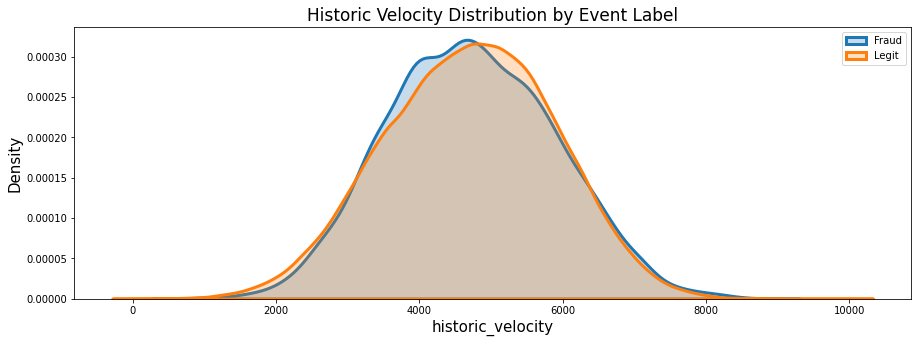

In [26]:
# To see transaction amount distribution for Historic Velocity column:

distplot_viz(
    data=df_data,
    column="historic_velocity",
    separate_column="EVENT_LABEL",
    condition_1="fraud",
    condition_2="legit",
    label1="Fraud",
    label2="Legit",
    title="Historic Velocity Distribution by Event Label",
    color1="blue",
    color2="red",
)

In [27]:
list_of_column_descriptive = ["historic_velocity"]
print("Fraud transactions; \n")
df_descriptive_statistics(
    df_data[df_data["EVENT_LABEL"] == "fraud"], list_of_column_descriptive
)
print("Legit transactions; \n")
df_descriptive_statistics(
    df_data[df_data["EVENT_LABEL"] == "legit"], list_of_column_descriptive
)

Fraud transactions; 

       historic_velocity
count        8161.000000
mean         4722.540130
std          1168.436752
min           862.000000
25%          3884.000000
50%          4692.000000
75%          5550.000000
max          8732.000000

Mode: 
    historic_velocity
0             4761.0
1             4996.0

Legit transactions; 

       historic_velocity
count      141724.000000
mean         4701.028774
std          1189.613868
min            50.000000
25%          3871.000000
50%          4732.000000
75%          5548.000000
max          9999.000000

Mode: 
    historic_velocity
0             5070.0



__Findings__:  
* Fraudelent transaction's minimum value is 17 times bigger than legit transactions. 
* Distributions are approximately similar. 
* These information shows that fraudelent people most focuses on bigger historic velocity. Without the business knowledge hard to evaluate further. 

## Bivariate Relationships: Categorical Variables
### Billing States & Event Label

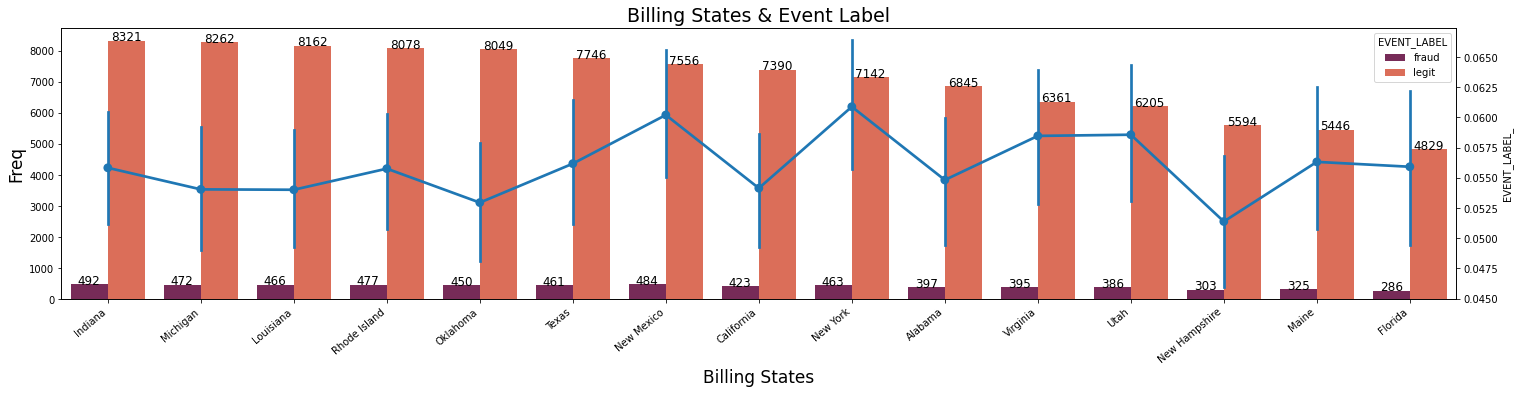

In [28]:
# To see count of fraud and legit transaction for each value in Billing States column:

filter_list = ["fraud", "legit"]
countplot_pointplot_viz_top15(
    df_data,
    filter_list,
    "billing_state",
    "EVENT_LABEL",
    "EVENT_LABEL_",
    "Billing States",
    "Freq",
    "Billing States & Event Label",
    palette="rocket",
    figsize_x=25,
    figsize_y=5,
)

__Findings__:
* Fraudelent transaction ratio compared to the fraudelent activities New York, New Mexico and Virginia are the highest states. 

### Billing City & Event Label:

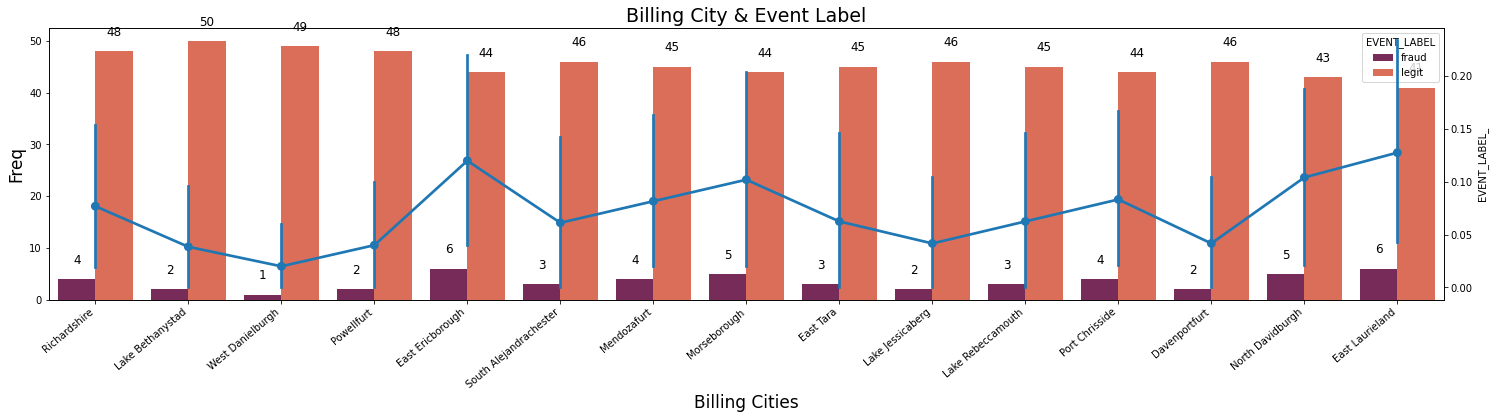

In [29]:
# To see count of fraud and legit transaction for each value in Billing City column:

filter_list = ["fraud", "legit"]
countplot_pointplot_viz_top15(
    df_data,
    filter_list,
    "billing_city",
    "EVENT_LABEL",
    "EVENT_LABEL_",
    "Billing Cities",
    "Freq",
    "Billing City & Event Label",
    palette="rocket",
    figsize_x=25,
    figsize_y=5,
)

__Findings__: 
* Transaction counts are similar for the top 15 initiates. 
* The max amount of transactions from a singular city is too small compared to the whole data set. 
* This column can't differentiate and deliver value in the analyse.

### Currency & Event Label:

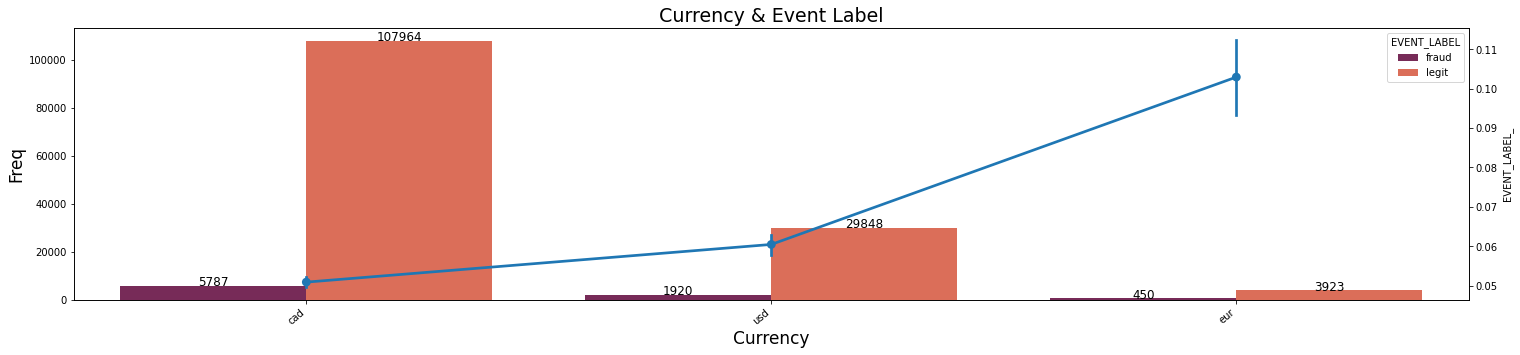

In [30]:
# To see count of fraud and legit transaction for each value in Currency column:

filter_list = ["fraud", "legit"]
countplot_pointplot_viz_top15(
    df_data,
    filter_list,
    "currency",
    "EVENT_LABEL",
    "EVENT_LABEL_",
    "Currency",
    "Freq",
    "Currency & Event Label",
    palette="rocket",
    figsize_x=25,
    figsize_y=5,
)

__Findings__:
* Highest number of transactions are occuring in Canada Dollar. 
* Euros has the highest fraudelent ratio.
* Transaction count makes the ratio fluctuates too much. We need additional columns to explain further.

### Transaction Types & Event Label: 

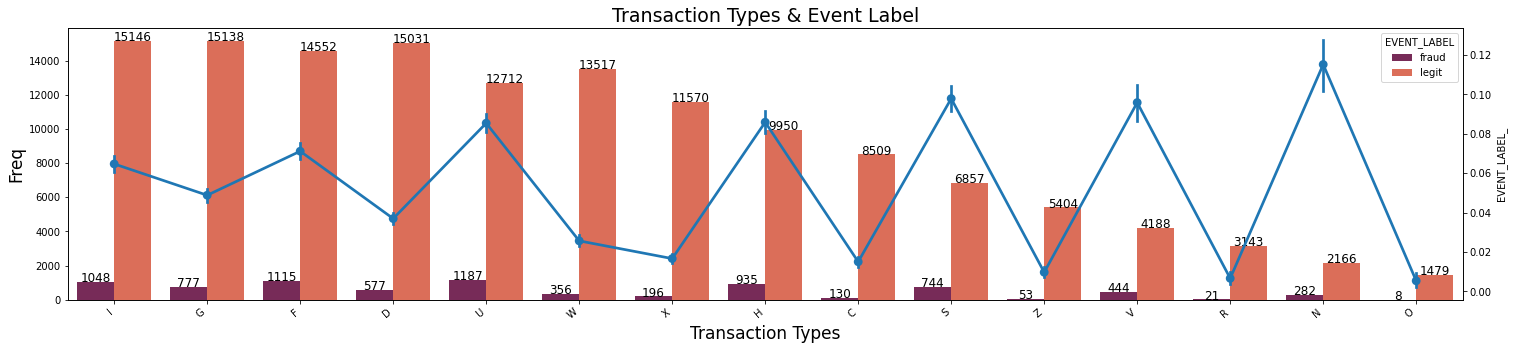

In [31]:
# To see count of fraud and legit transaction for each value in Transaction Types column:

filter_list = ["fraud", "legit"]
countplot_pointplot_viz_top15(
    df_data,
    filter_list,
    "transaction_type",
    "EVENT_LABEL",
    "EVENT_LABEL_",
    "Transaction Types",
    "Freq",
    "Transaction Types & Event Label",
    palette="rocket",
    figsize_x=25,
    figsize_y=5,
)

__Findings__: 
* Fraudelent transaction ratio compared to the fraudelent activities S, H and U are the highest transaction types. 
* N and V have the hightest fraudelent ratios but their transaction numbers are too low compared to others.

### Transaction Env & Event Label: 

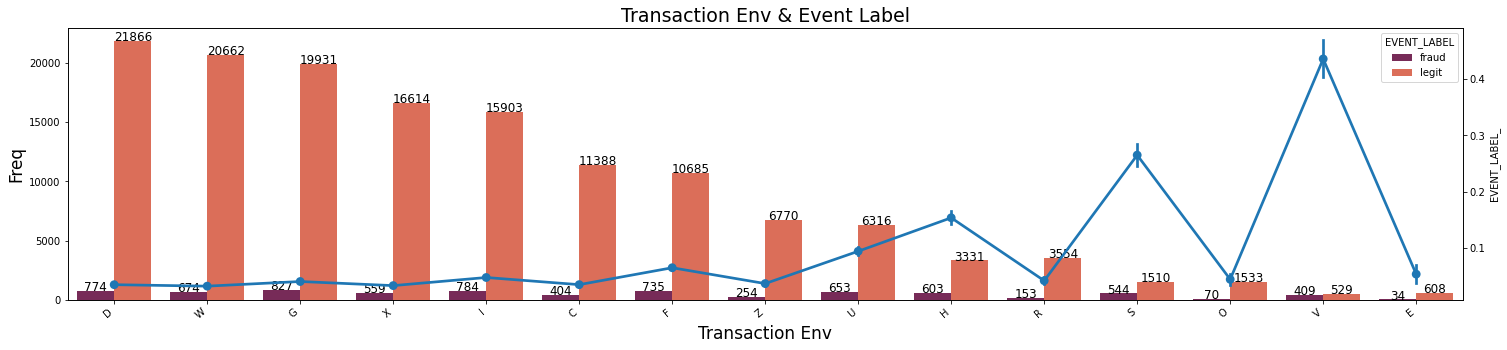

In [32]:
# To see count of fraud and legit transaction for each value in Transaction Env column:

filter_list = ["fraud", "legit"]
countplot_pointplot_viz_top15(
    df_data,
    filter_list,
    "transaction_env",
    "EVENT_LABEL",
    "EVENT_LABEL_",
    "Transaction Env",
    "Freq",
    "Transaction Env & Event Label",
    palette="rocket",
    figsize_x=25,
    figsize_y=5,
)

__Findings__: 
* V, S and H have the hightest fraudelent ratios but their transaction numbers are too low compared to others. 

### Transaction Initiate & Event Label: 

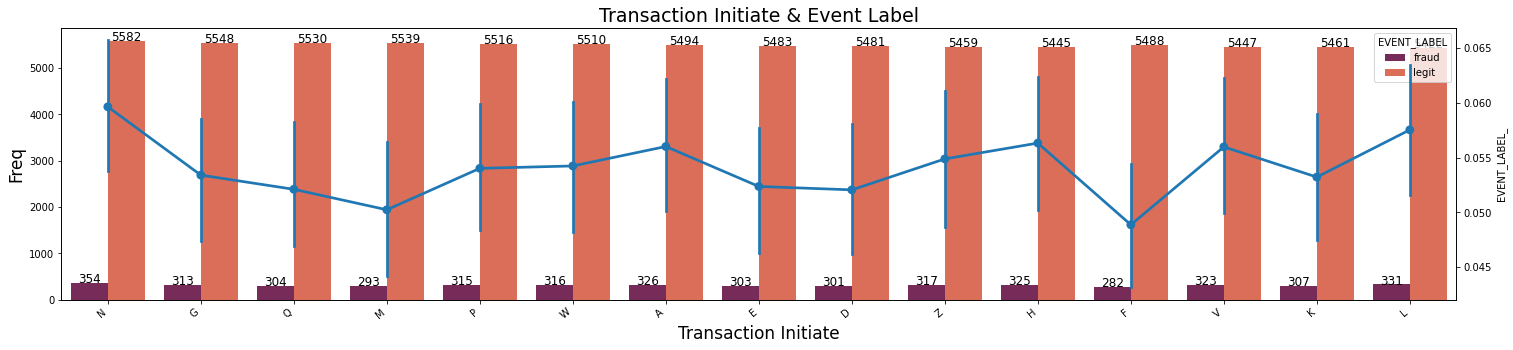

In [33]:
# To see count of fraud and legit transaction for each value in Transaction Initiate column:

filter_list = ["fraud", "legit"]
countplot_pointplot_viz_top15(
    df_data,
    filter_list,
    "tranaction_initiate",
    "EVENT_LABEL",
    "EVENT_LABEL_",
    "Transaction Initiate",
    "Freq",
    "Transaction Initiate & Event Label",
    palette="rocket",
    figsize_x=25,
    figsize_y=5,
)

__Findings__: 
* Transaction counts are similar for the top 15 initiates. 
* N, L and H have the highest fraudelent ratios.

### Card Bin & Event Label:

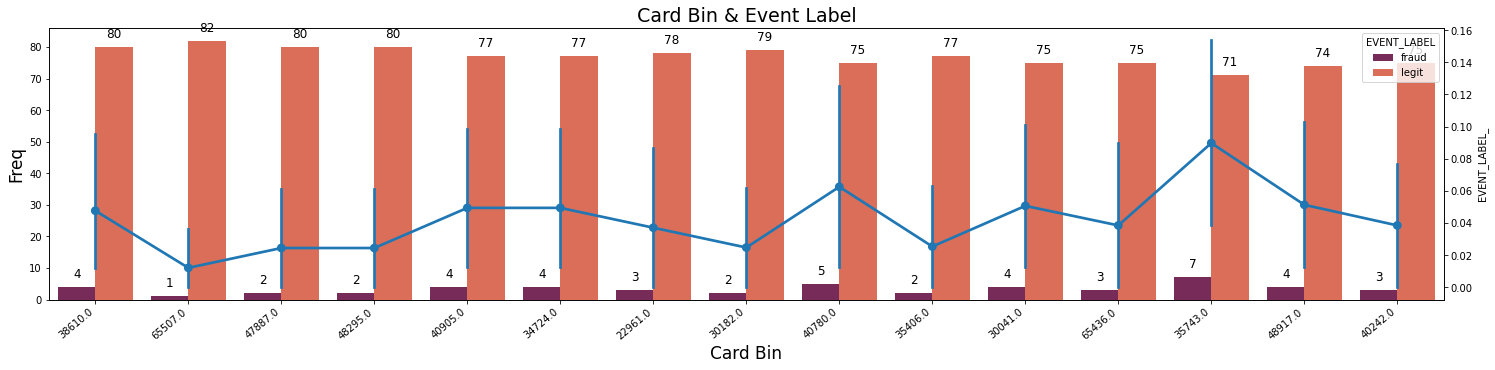

In [34]:
# To see count of fraud and legit transaction for each value in Card Bin column:

filter_list = ["fraud", "legit"]
countplot_pointplot_viz_top15(
    df_data,
    filter_list,
    "card_bin",
    "EVENT_LABEL",
    "EVENT_LABEL_",
    "Card Bin",
    "Freq",
    "Card Bin & Event Label",
    palette="rocket",
    figsize_x=25,
    figsize_y=5,
)

__Findings__:
* Transaction counts are similar for the top 15 initiates. 
* The max amount of transactions from a singular bank is too small compared to the whole data set. 
* This column can't differentiate and deliver value in the analyse.

### Email Domain & Event Label:  

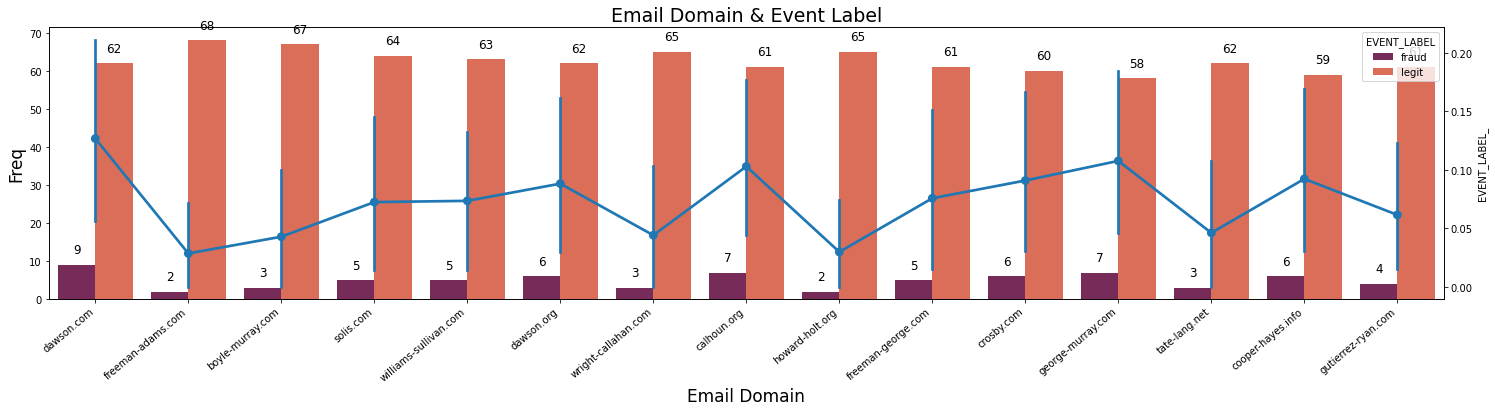

In [35]:
# To see count of fraud and legit transaction for each value in Email Domain column:

filter_list = ["fraud", "legit"]
countplot_pointplot_viz_top15(
    df_data,
    filter_list,
    "email_domain",
    "EVENT_LABEL",
    "EVENT_LABEL_",
    "Email Domain",
    "Freq",
    "Email Domain & Event Label",
    palette="rocket",
    figsize_x=25,
    figsize_y=5,
)

__Findings__: 
* Transaction counts are similar for the top 15 initiates. 
* The max amount of transactions from a singular email domain is too small compared to the whole data set. 
* This column can't differentiate and deliver value in the analyse.

### CVV & Event Label:  

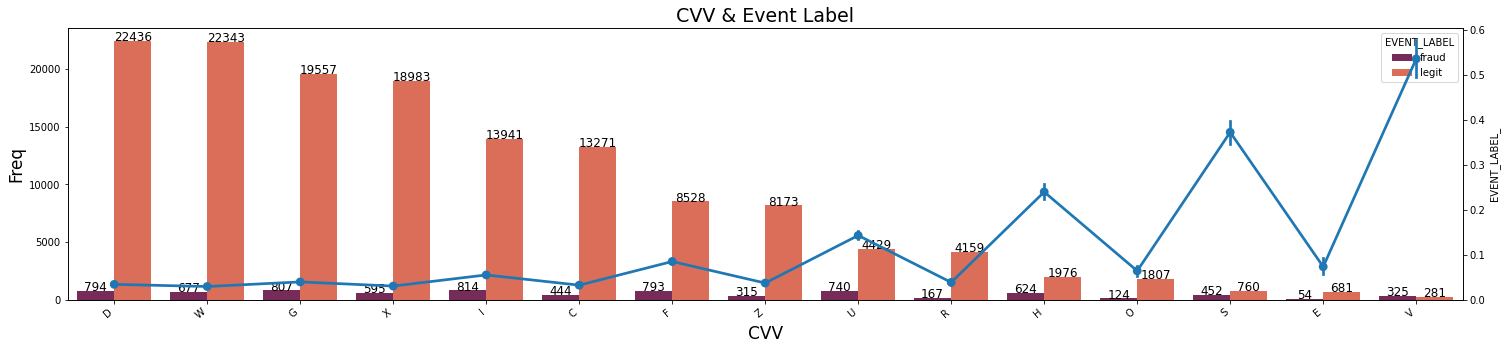

In [36]:
# To see count of fraud and legit transaction for each value in CVV column:

filter_list = ["fraud", "legit"]
countplot_pointplot_viz_top15(
    df_data,
    filter_list,
    "cvv",
    "EVENT_LABEL",
    "EVENT_LABEL_",
    "CVV",
    "Freq",
    "CVV & Event Label",
    palette="rocket",
    figsize_x=25,
    figsize_y=5,
)

__Findings__: 
* CVV is normally either 3 or 4 digit number. Without additional credit or debit card information this column doesn't add any value.  
* Lack of business knowledge and how the categorisation is being done, it is hard to use a randomly generated information.

### Signature Image & Event Label:  

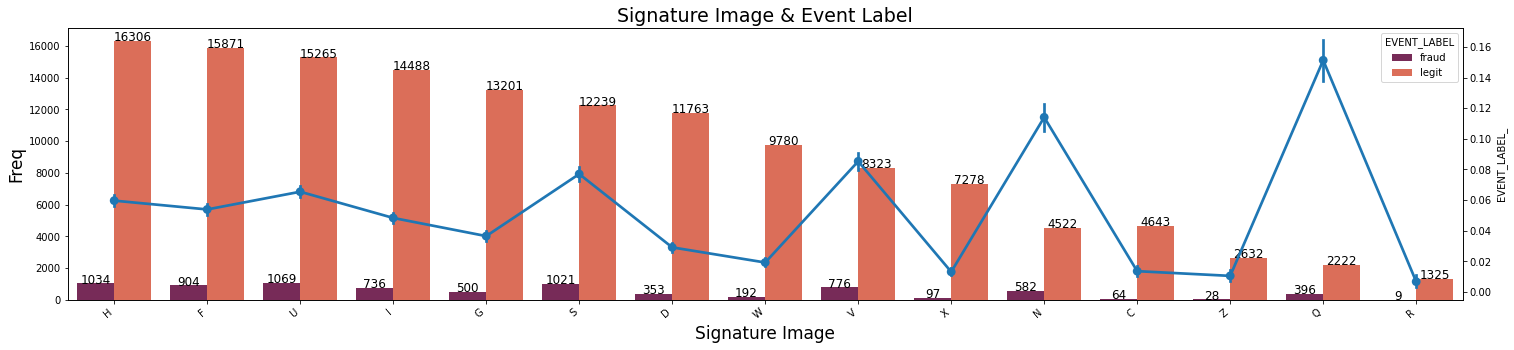

In [37]:
# To see count of fraud and legit transaction for each value in Signature Image column:

filter_list = ["fraud", "legit"]
countplot_pointplot_viz_top15(
    df_data,
    filter_list,
    "signature_image",
    "EVENT_LABEL",
    "EVENT_LABEL_",
    "Signature Image",
    "Freq",
    "Signature Image & Event Label",
    palette="rocket",
    figsize_x=25,
    figsize_y=5,
)

__Findings__:   
* Lack of business knowledge and how the categorisation is being done, it is hard to use a randomly generated information.

### Applicant Name & Event Label:  

posx and posy should be finite values
posx and posy should be finite values


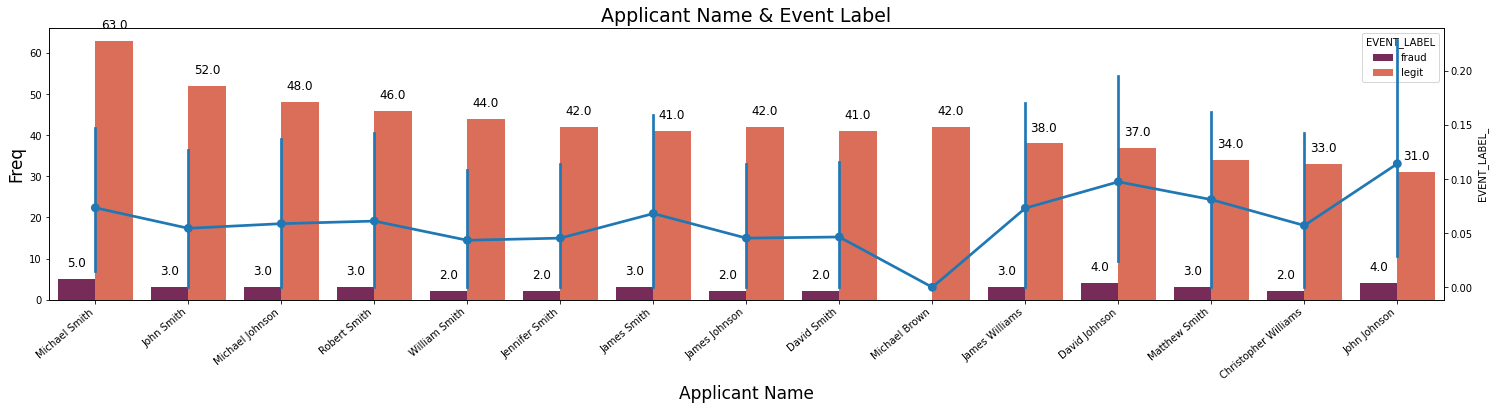

In [38]:
# To see count of fraud and legit transaction for each value in Applicant Name column:

filter_list = ["fraud", "legit"]
countplot_pointplot_viz_top15(
    df_data,
    filter_list,
    "applicant_name",
    "EVENT_LABEL",
    "EVENT_LABEL_",
    "Applicant Name",
    "Freq",
    "Applicant Name & Event Label",
    palette="rocket",
    figsize_x=25,
    figsize_y=5,
)

__Findings__: 
* Transaction counts are similar for the top 15 initiates. 
* The max amount of transactions from a singular applicant name is too small compared to the whole data set. 
* This column can't differentiate and deliver value in the analyse.

### Merchant ID & Event Label:  

In [39]:
print("Unique marchant id count: ", len(df_data["merchant_id"].unique()))

Unique marchant id count:  149884


__Findings__: 
* This column can't differentiate and deliver value in the analyse.
* Since the unique values of merchant id is too many, I am not going to analysis bi-variate relationship with target variable

### Locale & Event Label:  

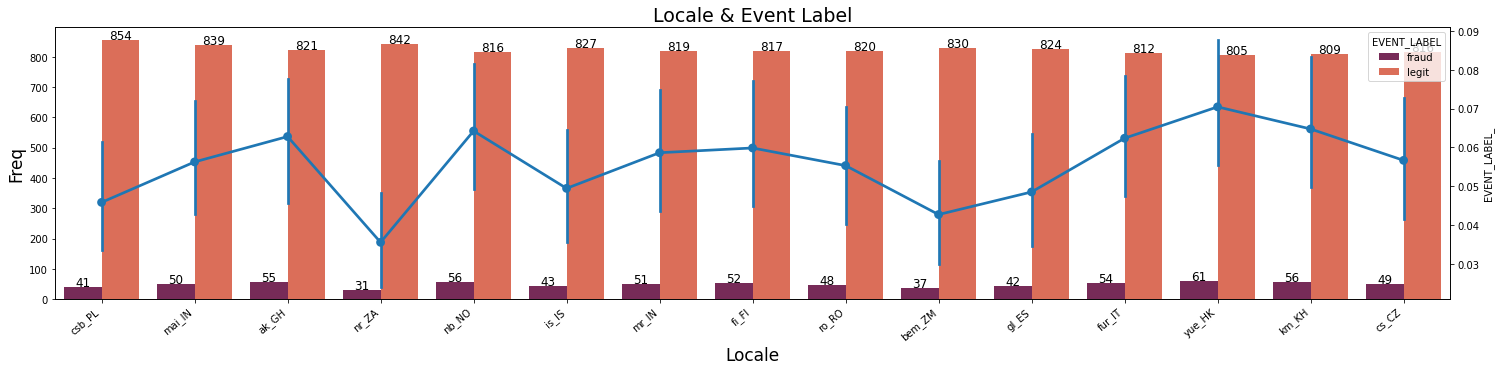

In [40]:
# To see count of fraud and legit transaction for each value in Locale column:

filter_list = ["fraud", "legit"]
countplot_pointplot_viz_top15(
    df_data,
    filter_list,
    "locale",
    "EVENT_LABEL",
    "EVENT_LABEL_",
    "Locale",
    "Freq",
    "Locale & Event Label",
    palette="rocket",
    figsize_x=25,
    figsize_y=5,
)

__Findings__: 
* Transaction counts are similar for the top 15 initiates. 
* The max amount of transactions from a singular locale is too small compared to the whole data set. 
* This column can't differentiate and deliver value in the analyse.

### Filtering Out Unneccessary Columns and Creating a New Data Frame

In [41]:
# Filtering out unneccassary columns based on the findings above:

multivariate_analysis_list = [
    "account_age_days",
    "transaction_amt",
    "transaction_adj_amt",
    "historic_velocity",
    "billing_state",
    "currency",
    "transaction_type",
    "transaction_env",
    "EVENT_TIMESTAMP",
    "tranaction_initiate",
    "days_since_last_logon",
    "EVENT_LABEL",
    "EVENT_LABEL_",
    "Weekday",
    "Hour",
    "Day",
    "Year",
    "Month",
]

df_data_core = df_data[multivariate_analysis_list].copy()

In [42]:
# New data frame is created:

df_data_core.head()

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,billing_state,currency,transaction_type,transaction_env,EVENT_TIMESTAMP,tranaction_initiate,days_since_last_logon,EVENT_LABEL,EVENT_LABEL_,Weekday,Hour,Day,Year,Month
0,3371.0,2167.0,56.0,2572.0,California,cad,U,X,2020-12-29 09:05:00,O,59.0,legit,0,1.0,9.0,29.0,2020.0,12.0
1,2714.0,2045.0,48.0,4517.0,Florida,cad,H,W,2021-06-22 18:05:00,J,0.0,legit,0,1.0,18.0,22.0,2021.0,6.0
2,6987.0,2892.0,61.0,5007.0,Utah,cad,X,X,2021-10-05 13:48:00,T,83.0,legit,0,1.0,13.0,5.0,2021.0,10.0
3,2712.0,3040.0,28.0,6022.0,Virginia,usd,C,N,2021-11-03 07:36:00,M,24.0,legit,0,2.0,7.0,3.0,2021.0,11.0
4,3598.0,2976.0,66.0,2600.0,South Carolina,cad,F,G,2021-03-27 06:13:00,K,21.0,legit,0,5.0,6.0,27.0,2021.0,3.0


## Multivariate Relationships

In Multivariate Relationships I will try to find out the most frequent and high fraud ratio combinations between two variables over EVENT_LABEL column

## Multivariate Relationships: Geo Combinations

### Billing State & Currency

In [43]:
# Top 5 most frequent fraudulent transactions and their relative fraud ratios
fraud_ratio_calculator_for_two_categoric_variables(
    df_data_core, "billing_state", "currency"
).sort_values(
    by=["EVENT_LABEL__fraud", "EVENT_LABEL_fraud_ratio"], ascending=False
).head()

,billing_state,currency,EVENT_LABEL__all,EVENT_LABEL__fraud,EVENT_LABEL_fraud_ratio
110,Texas,cad,6525,339.0,0.051954
57,Michigan,cad,6471,337.0,0.052079
100,Rhode Island,cad,6587,327.0,0.049643
11,California,cad,6466,323.0,0.049954
0,Alabama,cad,6178,320.0,0.051797


### Billing State & Weekday

In [44]:
# Top 5 most frequent fraudulent transactions and their relative fraud ratios
fraud_ratio_calculator_for_two_categoric_variables(
    df_data_core, "billing_state", "Weekday"
).sort_values(
    by=["EVENT_LABEL__fraud", "EVENT_LABEL_fraud_ratio"], ascending=False
).head()

,billing_state,Weekday,EVENT_LABEL__all,EVENT_LABEL__fraud,EVENT_LABEL_fraud_ratio
94,Indiana,3.0,1238,85.0,0.068659
197,New Mexico,4.0,1194,84.0,0.070352
229,Oklahoma,4.0,1212,82.0,0.067657
240,Rhode Island,2.0,1248,82.0,0.065705
203,New York,3.0,1102,80.0,0.072595


### Billing State & Trensaction Types

In [45]:
# Top 5 most frequent fraudulent transactions and their relative fraud ratios
fraud_ratio_calculator_for_two_categoric_variables(
    df_data_core, "billing_state", "transaction_type"
).sort_values(
    by=["EVENT_LABEL__fraud", "EVENT_LABEL_fraud_ratio"], ascending=False
).head()

,billing_state,transaction_type,EVENT_LABEL__all,EVENT_LABEL__fraud,EVENT_LABEL_fraud_ratio
307,Louisiana,U,626,87.0,0.138978
520,New Mexico,U,405,76.0,0.187654
361,Michigan,F,888,73.0,0.082207
543,New York,U,373,71.0,0.190349
507,New Mexico,F,571,71.0,0.124343


### Billing State & Transaction Env

In [46]:
# Top 5 most frequent fraudulent transactions and their relative fraud ratios
fraud_ratio_calculator_for_two_categoric_variables(
    df_data_core, "billing_state", "transaction_env"
).sort_values(
    by=["EVENT_LABEL__fraud", "EVENT_LABEL_fraud_ratio"], ascending=False
).head()

,billing_state,transaction_env,EVENT_LABEL__all,EVENT_LABEL__fraud,EVENT_LABEL_fraud_ratio
631,Rhode Island,D,1327,66.0,0.049736
371,Michigan,G,1175,61.0,0.051915
513,New Mexico,F,606,60.0,0.099010
81,California,G,1060,60.0,0.056604
634,Rhode Island,G,1176,60.0,0.051020


### Billing State & Transaction Amount

In [47]:
# Top 5 most frequent fraudulent transactions and their relative over transaction amount
fraud_ratio_calculator_for_numeric_categoric_variables(
    df_data_core, "billing_state", "transaction_amt"
).sort_values(
    by=["transaction_amt_fraud", "numeric_fraud_ratio"], ascending=False
).head()

,billing_state,transaction_amt_total,transaction_amt_fraud,numeric_fraud_ratio
13,Indiana,22624528.0,1375624.0,0.060802
30,New Mexico,21408854.0,1348608.0,0.062993
38,Rhode Island,20671038.0,1324676.0,0.064084
31,New York,20622089.0,1321570.0,0.064085
21,Michigan,21443253.0,1317987.0,0.061464


## Multivariate Relationships: Time Combinations

### Weekday & Hour

In [ ]:
# Top 5 most frequent fraudulent transactions and their relative fraud ratios
fraud_ratio_calculator_for_two_categoric_variables(
    df_data_core, "Weekday", "Hour"
).sort_values(
    by=["EVENT_LABEL__fraud", "EVENT_LABEL_fraud_ratio"], ascending=False
).head()

### Weekday & Transaction Amount

In [48]:
# Top 5 most frequent fraudulent transactions and their relative over transaction amount
fraud_ratio_calculator_for_numeric_categoric_variables(
    df_data_core, "Weekday", "transaction_amt"
).sort_values(
    by=["transaction_amt_fraud", "numeric_fraud_ratio"], ascending=False
).head()

,Weekday,transaction_amt_total,transaction_amt_fraud,numeric_fraud_ratio
4,4.0,54027420.0,3493926.0,0.064669
5,5.0,55881213.0,3436931.0,0.061504
3,3.0,53356119.0,3359956.0,0.062972
1,1.0,53101939.0,3216448.0,0.060571
6,6.0,53913930.0,3211317.0,0.059564


### Hour & Transation Amount

In [49]:
# Top 5 most frequent fraudulent transactions and their relative over transaction amount
fraud_ratio_calculator_for_numeric_categoric_variables(
    df_data_core, "Hour", "transaction_amt"
).sort_values(
    by=["transaction_amt_fraud", "numeric_fraud_ratio"], ascending=False
).head()

,Hour,transaction_amt_total,transaction_amt_fraud,numeric_fraud_ratio
17,17.0,15713784.0,1059609.0,0.067432
18,18.0,15902905.0,1058895.0,0.066585
23,23.0,15790676.0,1056156.0,0.066885
1,1.0,15767800.0,1048136.0,0.066473
2,2.0,15586484.0,1006000.0,0.064543


## Multivariate Relationships: Transactional Combinations

### Transaction Type & Transaction Env

In [50]:
# Top 5 most frequent fraudulent transactions and their relative fraud ratios
fraud_ratio_calculator_for_two_categoric_variables(
    df_data_core, "transaction_type", "transaction_env"
).sort_values(
    by=["EVENT_LABEL__fraud", "EVENT_LABEL_fraud_ratio"], ascending=False
).head()

,transaction_type,transaction_env,EVENT_LABEL__all,EVENT_LABEL__fraud,EVENT_LABEL_fraud_ratio
352,U,D,2037,124.0,0.060874
357,U,I,1454,116.0,0.079780
92,F,F,1017,114.0,0.112094
168,I,G,2042,109.0,0.053379
95,F,I,1621,108.0,0.066626


### Transaction Type & Transaction Initiate

In [51]:
# Top 5 most frequent fraudulent transactions and their relative fraud ratios
fraud_ratio_calculator_for_two_categoric_variables(
    df_data_core, "transaction_type", "tranaction_initiate"
).sort_values(
    by=["EVENT_LABEL__fraud", "EVENT_LABEL_fraud_ratio"], ascending=False
).head()

,transaction_type,tranaction_initiate,EVENT_LABEL__all,EVENT_LABEL__fraud,EVENT_LABEL_fraud_ratio
482,U,N,578,59.0,0.102076
494,U,Z,578,59.0,0.102076
128,F,N,663,56.0,0.084465
134,F,T,610,55.0,0.090164
480,U,L,568,53.0,0.093310


### Transaction Type & Currency

In [52]:
# Top 5 most frequent fraudulent transactions and their relative fraud ratios
fraud_ratio_calculator_for_two_categoric_variables(
    df_data_core, "currency", "transaction_type"
).sort_values(
    by=["EVENT_LABEL__fraud", "EVENT_LABEL_fraud_ratio"], ascending=False
).head()

,currency,transaction_type,EVENT_LABEL__all,EVENT_LABEL__fraud,EVENT_LABEL_fraud_ratio
20,cad,U,12347,847.0,0.068600
5,cad,F,13597,784.0,0.057660
8,cad,I,13399,716.0,0.053437
7,cad,H,9839,704.0,0.071552
18,cad,S,6913,566.0,0.081875


### Transaction Amount & Currency

In [53]:
# Top 5 most frequent fraudulent transactions and their relative over transaction amount
fraud_ratio_calculator_for_numeric_categoric_variables(
    df_data_core, "currency", "transaction_amt"
).sort_values(
    by=["transaction_amt_fraud", "numeric_fraud_ratio"], ascending=False
).head()

,currency,transaction_amt_total,transaction_amt_fraud,numeric_fraud_ratio
0,cad,284245084.0,16402695.0,0.057706
2,usd,83958744.0,5425846.0,0.064625
1,eur,9410416.0,1263044.0,0.134218


### Transaction Type & Transaction Amount

In [54]:
# Top 5 most frequent fraudulent transactions and their relative over transaction amount
fraud_ratio_calculator_for_numeric_categoric_variables(
    df_data_core, "transaction_type", "transaction_amt"
).sort_values(
    by=["transaction_amt_fraud", "numeric_fraud_ratio"], ascending=False
).head()

,transaction_type,transaction_amt_total,transaction_amt_fraud,numeric_fraud_ratio
20,U,31928279.0,3383220.0,0.105963
5,F,36800268.0,3171004.0,0.086168
8,I,39698553.0,2976831.0,0.074986
7,H,24508912.0,2659771.0,0.108523
6,G,40974039.0,2188014.0,0.053400


In [ ]:
### Transaction Type & Transaction Env

In [55]:
# Top 5 most frequent fraudulent transactions and their relative over transaction amount
fraud_ratio_calculator_for_numeric_categoric_variables(
    df_data_core, "transaction_env", "transaction_amt"
).sort_values(
    by=["transaction_amt_fraud", "numeric_fraud_ratio"], ascending=False
).head()

,transaction_env,transaction_amt_total,transaction_amt_fraud,numeric_fraud_ratio
6,G,52545221.0,2299965.0,0.043771
3,D,57151428.0,2146292.0,0.037554
8,I,42517381.0,2131185.0,0.050125
5,F,29140119.0,1987082.0,0.068191
22,W,53378013.0,1919070.0,0.035952


# Segments & Metrics

## Metrics:

## Segments:
* __Rule 1__:If the transaction amount is higher than 25% quantile of fraud transaction amount and its currency is Euro this transaction can be fraud. (If the transaction amount that is less than 814 is legit.)  
* __Rule 2__:Account age day is higher than 25% quantile of fraud transaction account age day can be fraud. (If the account age is less than 900, the transaction is legit.)
* __Rule 3__:Friday is the most risky day. If transaction is on Friday at 22:00 or 23:00 it can be fraud. 
* __Rule 4__:Transaction adj amt is less than 15 it is fraud. For catching more fraudulent activities we can look less than 20.  
* __Rule 5__:New Mexico and New York have the biggest fraudulent transactions. If we combine these cities with that transaction amounts are higher than 25% quantile of fraud transaction amount  we can catch fraudulent transactions.  
* __Rule 6__:USD currency and transaction types U, H and S combinations are so risky by fraudulent activities.  
* __Rule 7__:U Transaction type is so risky.  If New Mexico and New York's transaction type is U, the transaction can be risky.
* __Rule 8__:H transaction_env is so risky. If New Mexico and New York's transaction env is H, the transaction can be risky.
* __Rule 9__:H transaction_env and U tansaction type are so risky. If we combine them we can catch fraudulent transactions. 

__Rule 1__:
* If the transaction amount is higher than 25% quantile of fraud transaction amount and its currency is Euro this transaction can be fraud. (If the transaction amount that is less than 814 is legit.)

In [ ]:
# Hit rate on $
(
    df_data[
        (
            df_data["transaction_amt"]
            >= df_data[df_data["EVENT_LABEL"] == "fraud"]["transaction_amt"].quantile(
                q=0.25
            )
        )
        & (df_data["currency"] == "eur")
    ]
    .groupby(by=["EVENT_LABEL"])["transaction_amt"]
    .sum()
    .reset_index()
    .iloc[0]
)

In [ ]:
# hit rate on $
df_data[
    (
        df_data["transaction_amt"]
        >= df_data[df_data["EVENT_LABEL"] == "fraud"]["transaction_amt"].quantile(
            q=0.25
        )
    )
    & (df_data["currency"] == "eur")
]["transaction_amt"].sum()

In [ ]:
# Hit Rate on $ 
# /$ of fraud transactions hit by rule / #/$ of total transactions hit by rule
990339 / (990339.0 + 2213750.0)

In [ ]:
# Catch Rate on $
# /$ of fraud transactions hit by rule / #/$ of all fraud transactions
990339.0 / 

In [ ]:
# Rejection Rate on $
# /$ of transactions rejected / #/$ of all attempted transactions

791 / (322 + 791)

In [ ]:
# hit rate by #
df_data[(df_data["transaction_amt"] >= 2500) & (df_data["currency"] == "eur")].groupby(
    by=["EVENT_LABEL"]
)["transaction_amt"].count()

In [ ]:
# Hit Rate by #
# /$ of fraud transactions hit by rule / #/$ of total transactions hit by rule
990339 / (990339.0 + 2213750.0)

In [ ]:
# Catch Rate by #
# /$ of fraud transactions hit by rule / #/$ of all fraud transactions

322 / 8164

In [ ]:
# Rejection Rate by #
# /$ of transactions rejected / #/$ of all attempted transactions

791 / (322 + 791)

__Rule 2__:
* Account age day is higher than 25% quantile of fraud transaction account age day can be fraud. (If the account age is less than 900, the transaction is legit.)

In [ ]:
df_data[(df_data["account_age_days"] >= 4700)].groupby(by=["EVENT_LABEL"])[
    "account_age_days"
].count()

In [ ]:
# Hit Rate
# /$ of fraud transactions hit by rule / #/$ of total transactions hit by rule
6317 / (6317 + 67122)

In [ ]:
# Catch Rate
# /$ of fraud transactions hit by rule / #/$ of all fraud transactions

6317 / 8164

__Rule 3__:
* Friday is the most risky day. If transaction is on Friday at 22:00 or 23:00 it can be fraud.

In [ ]:
df_data[(df_data["Weekday"] == 4.0) & (df_data["Hour"].isin([22.0, 23.0]))].groupby(
    by=["EVENT_LABEL"]
)["Weekday"].count()

In [ ]:
# Hit Rate
# /$ of fraud transactions hit by rule / #/$ of total transactions hit by rule
139 / (139 + 1661)

In [ ]:
# Catch Rate
# /$ of fraud transactions hit by rule / #/$ of all fraud transactions

139 / 8164

__Rule 4__:
* Transaction adj amt is less than 15 it is fraud. For catching more fraudulent activities we can look less than 20.

In [ ]:
df_data[(df_data["transaction_adj_amt"] <= 20)].groupby(by=["EVENT_LABEL"])[
    "transaction_adj_amt"
].count()

In [ ]:
# Hit Rate
# /$ of fraud transactions hit by rule / #/$ of total transactions hit by rule
276 / (276 + 22)

In [ ]:
# Catch Rate
# /$ of fraud transactions hit by rule / #/$ of all fraud transactions

276 / 8164

__Rule 5__:
* New Mexico and New York have the biggest fraudulent transactions. If we combine these cities with that transaction amounts are higher than 25% quantile of fraud transaction amount  we can catch fraudulent transactions.

In [ ]:
df_data[
    (df_data["transaction_amt"] >= 2545)
    & (df_data["billing_state"].isin(["New Mexico", "New York"]))
].groupby(by=["EVENT_LABEL"])["transaction_adj_amt"].count()

In [ ]:
# Hit Rate
# /$ of fraud transactions hit by rule / #/$ of total transactions hit by rule
946 / (946 + 14688)

In [ ]:
# Catch Rate
# /$ of fraud transactions hit by rule / #/$ of all fraud transactions

946 / 8164

__Rule 6__:
* USD currency and transaction types U, H and S combinations are so risky by fraudulent activities.

In [ ]:
df_data[
    (df_data["currency"] == "eur")
    & ((df_data["transaction_type"].isin(["U", "H", "S"])))
].groupby(by=["EVENT_LABEL"])["transaction_adj_amt"].count()

In [ ]:
# Hit Rate
# /$ of fraud transactions hit by rule / #/$ of total transactions hit by rule
173 / (173 + 1519)

In [ ]:
# Catch Rate
# /$ of fraud transactions hit by rule / #/$ of all fraud transactions

173 / 8164

__Rule 7__:
* U Transaction type is so risky.  If New Mexico and New York's transaction type is U, the transaction can be risky.

In [ ]:
df_data[
    (df_data["transaction_type"] == "U")
    & ((df_data["billing_state"].isin(["New Mexico", "New York"])))
].groupby(by=["EVENT_LABEL"])["transaction_adj_amt"].count()

In [ ]:
# Hit Rate
# /$ of fraud transactions hit by rule / #/$ of total transactions hit by rule
147 / (147 + 631)

In [ ]:
# Catch Rate
# /$ of fraud transactions hit by rule / #/$ of all fraud transactions

147 / 8164

__Rule 8__:
* H transaction_env is so risky. If New Mexico and New York's transaction env is H, the transaction can be risky.

In [ ]:
df_data[
    (df_data["transaction_env"] == "H")
    & ((df_data["billing_state"].isin(["New Mexico", "New York"])))
].groupby(by=["EVENT_LABEL"])["transaction_adj_amt"].count()

In [ ]:
# Hit Rate
# /$ of fraud transactions hit by rule / #/$ of total transactions hit by rule
94 / (94 + 339)

In [ ]:
# Catch Rate
# /$ of fraud transactions hit by rule / #/$ of all fraud transactions

94 / 8164

__Rule 9__:
* H transaction_env and U tansaction type are so risky. If we combine them we can catch fraudulent transactions. 

In [ ]:
df_data[
    (df_data["transaction_env"] == "H") & (df_data["transaction_type"] == "U")
].groupby(by=["EVENT_LABEL"])["transaction_adj_amt"].count()

In [ ]:
# Hit Rate
# /$ of fraud transactions hit by rule / #/$ of total transactions hit by rule
93 / (93 + 285)

In [ ]:
# Catch Rate
# /$ of fraud transactions hit by rule / #/$ of all fraud transactions

93 / 8164